In [1]:
from scipy.io import loadmat
import os
import numpy as np
from sklearn import model_selection
from scipy.optimize import curve_fit
from sklearn import metrics
import matplotlib.pyplot as plt

# Load Data

In [2]:
DATA_FOLER = 'data'

In [3]:
x_json = loadmat(os.path.join(DATA_FOLER, 'Pout vs. Current.mat'))

In [4]:
current = x_json['Current']
topmw = x_json['Pout1_normalized']

In [5]:
print(current.shape)
print(topmw.shape)

(1, 10000)
(1, 10000)


In [6]:
current = np.squeeze(current)
topmw = np.squeeze(topmw)

In [7]:
print(current.shape)
print(topmw.shape)

(10000,)
(10000,)


## Filtering

In [8]:
valid_mask = topmw <= 1.0
current = current[valid_mask]
topmw = topmw[valid_mask]

In [9]:
print(current.shape)
print(topmw.shape)

(9399,)
(9399,)


# Curve Fitting

## Split Training and Testing Data

In [10]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(current, topmw, test_size=0.25, random_state=3)

In [11]:
yy_train = np.arccos(y_train * 2 - 1) 
yy_test = np.arccos(y_test * 2 - 1)

## Plot Data

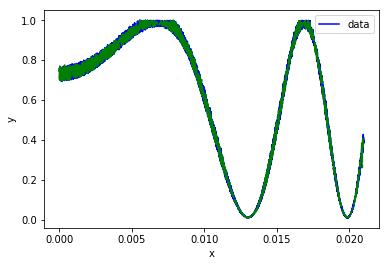

In [12]:
sort_indices_train = np.argsort(x_train)
sort_indices_test = np.argsort(x_test)

plt.plot(x_train[sort_indices_train], y_train[sort_indices_train], 'b-', label='data')
plt.plot(x_test[sort_indices_test], y_test[sort_indices_test], 'g--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Training 

#### Current to Power

In [13]:
def polynomial5(x, a, b, c, d):
    p = a * x**5 + b * x ** 4 + c * x**3 + d * x**2
    return p

def polynomial3(x, c, d):
    p = d * x**3 + c * x**2
    return p

#### Make Sure Power Value is Between 0 and Pi

In [14]:
def num_to_pi(num):
    
    if num > np.pi * 2:
        num = num % (np.pi * 2)
    
    if num < 0:
        num = np.ceil(np.abs(num) // (np.pi * 2)) * np.pi * 2 + num
        
    if num > np.pi:
        num = 2 * np.pi - num
        
    return num

vfunc_num_to_pi = np.vectorize(num_to_pi)

#### Fitting Curve

In [15]:
def func(x, a, b, c, d, alpha, beta):
    p = polynomial5(x, a, b, c, d)
    phi = alpha * p + beta
    
    phi = vfunc_num_to_pi(phi)

    return phi

In [16]:
popt, pcov = curve_fit(func, x_train, yy_train)

### Parameter!

In [17]:
popt

array([ 2.09291960e+07, -9.26464246e+05,  1.32102269e+04, -6.00453499e+01,
        3.52949181e+03,  1.48997469e+00])

### Training r2

In [18]:
metrics.r2_score(yy_train,  func(x_train, *popt))

0.7591045506946557

### Plot Training Data with Fitted Curve

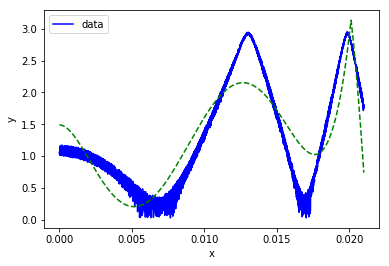

In [19]:
sort_indices = np.argsort(x_train)

plt.plot(x_train[sort_indices], yy_train[sort_indices], 'b-', label='data')
plt.plot(x_train[sort_indices], func(x_train[sort_indices], *popt), 'g--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Testing

In [20]:
yy_pred = func(x_test, *popt)

### Testing R2

In [21]:
metrics.r2_score(yy_test, yy_pred)

0.7609486276635021

### Plot Test Data with Fitted Curve

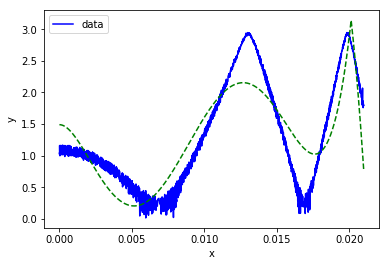

In [22]:
sort_indices = np.argsort(x_test)

plt.plot(x_test[sort_indices], yy_test[sort_indices], 'b-', label='data')
plt.plot(x_test[sort_indices], func(x_test[sort_indices], *popt), 'g--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()